In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

import sys
path_to_code_folder = './VAE' # change this to your local procject path
sys.path.insert(0,path_to_code_folder )
from load_dataset import load_kdd_to_df,load_dataset
from vae import VAE
from train import train
import os
from measurements import plot_latent_space,plot_label_latent_space,plot_reconstruction_error,get_reconstruction_error,metrics,get_best_threshold_value,pick_best_model_from_csv
from sklearn.metrics import classification_report
from utils import load_model

D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is 

In [2]:
urls = [
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz",
        "http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names"
        ]

In [3]:
sns.set()

### Dataset Distrubution:

<BarContainer object of 2 artists>

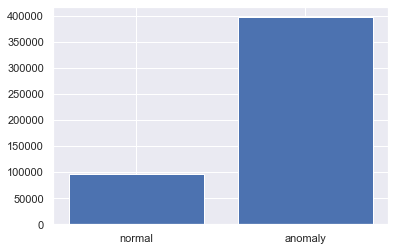

In [4]:
norm_samples, norm_labels, attack_samples, attack_labels = load_kdd_to_df()
plt.bar(['normal','anomaly'],[len(norm_samples),len(attack_samples)])

In [5]:
seed = 42
x_train,X_test,Y_test = load_dataset(train_precent=0.8, seed = seed)

<BarContainer object of 2 artists>

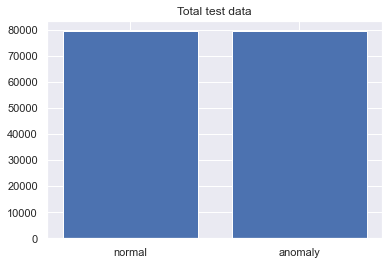

In [6]:
plt.title('Total test data')
plt.bar(['normal','anomaly'],[len(Y_test[Y_test==0]),len(Y_test[Y_test==1])])

In [7]:
X_val, x_test, y_val, y_test = train_test_split(X_test,Y_test, test_size=0.2, random_state = seed)


<BarContainer object of 2 artists>

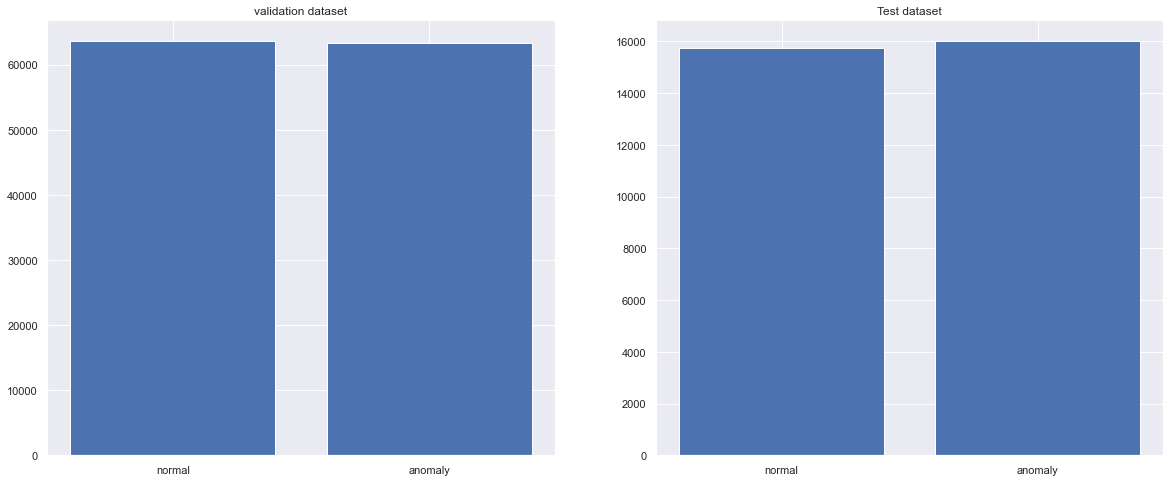

In [8]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title('validation dataset')
plt.bar(['normal','anomaly'],[len(y_val[y_val==0]),len(y_val[y_val==1])])
plt.subplot(1, 2, 2)
plt.title('Test dataset')
plt.bar(['normal','anomaly'],[len(y_test[y_test==0]),len(y_test[y_test==1])])

### training model :

In [9]:
LEARNING_RATE =0.0001
BATCH_SIZE = 64
EPOCHS = 10
vae = train(x_train,LEARNING_RATE,
            BATCH_SIZE,
            EPOCHS,encoder_dense_layers =(80,40),
            decoder_dense_layers =(40, 80),
            latent_space_dim =2,
            beta =1,
            reconstruction_loss_weight = 1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 121)]        0                                            
__________________________________________________________________________________________________
encoder_dense_layer_1 (Dense)   (None, 80)           9760        encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_dense_layer_2 (Dense)   (None, 40)           3240        encoder_dense_layer_1[0][0]      
__________________________________________________________________________________________________
mu (Dense)                      (None, 2)            82          encoder_

### training data latent space represention:

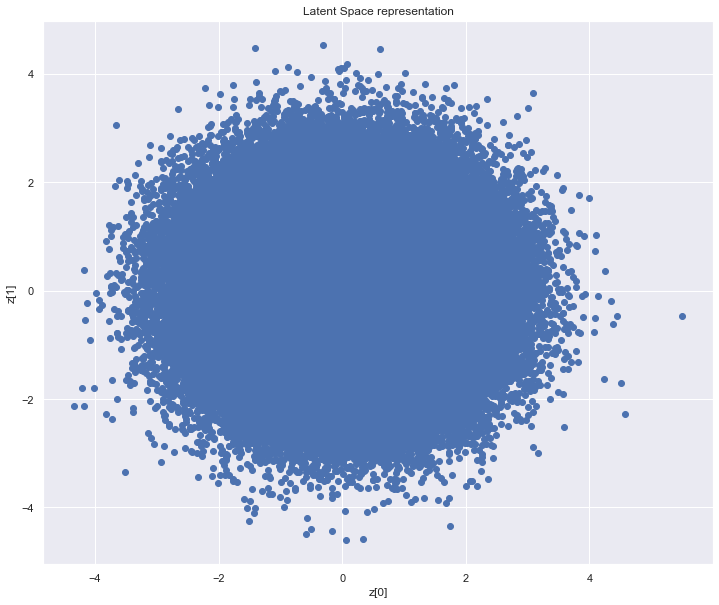

In [10]:
plot_latent_space(vae, x_train)

### training data reconstruction error:

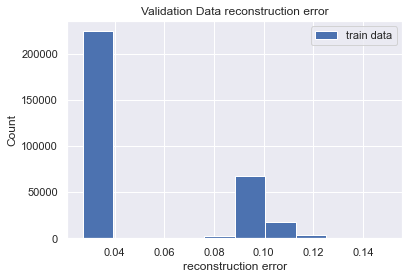

In [11]:
plot_reconstruction_error(vae, x_train)

### validation data reconstruction error:

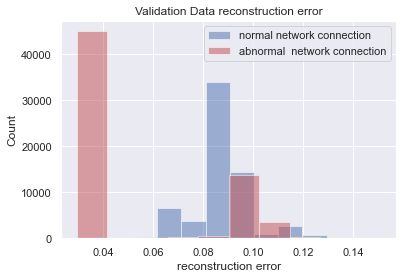

In [12]:
plot_reconstruction_error(vae, X_val, label = y_val )

### validation data latent space represention:

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


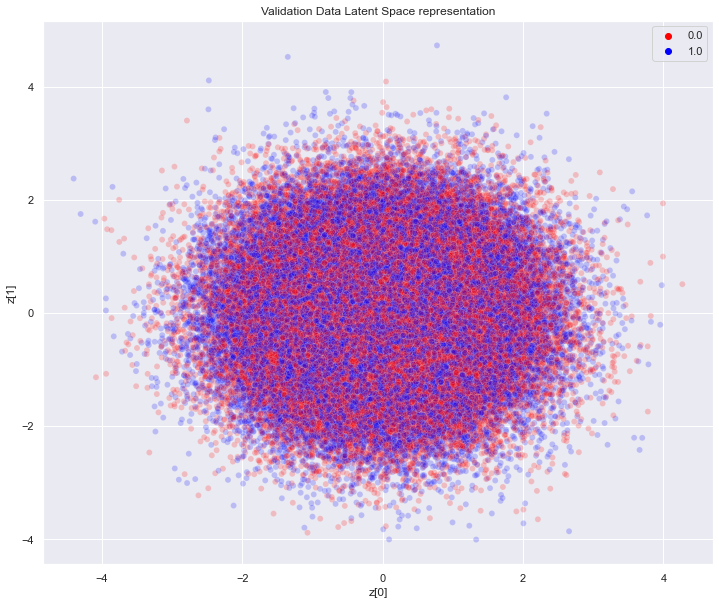

In [13]:
plot_label_latent_space(vae, X_val,y_val)

### pick the best resonstruction error value 

In [14]:
x_val_pred, x_val_pred_latent_representations = vae.reconstruct(X_val)
metrics_df = metrics(X_val, x_val_pred, y_val)
metrics_df.head()


,threshold,F1,Precision,Recall,AUC,TN,FN,TP,FP,Accuracy
0,0.000000,0.665707,0.498921,1.0,0.5,0,0,63342,63616,0.498921
1,0.003061,0.665707,0.498921,1.0,0.5,0,0,63342,63616,0.498921
2,0.006122,0.665707,0.498921,1.0,0.5,0,0,63342,63616,0.498921
3,0.009184,0.665707,0.498921,1.0,0.5,0,0,63342,63616,0.498921
4,0.012245,0.665707,0.498921,1.0,0.5,0,0,63342,63616,0.498921


In [15]:
best_th = get_best_threshold_value(metrics_df,["Accuracy"])


max value of Accuracy is 0.8539359473211613
Th is 0.04591836734693877


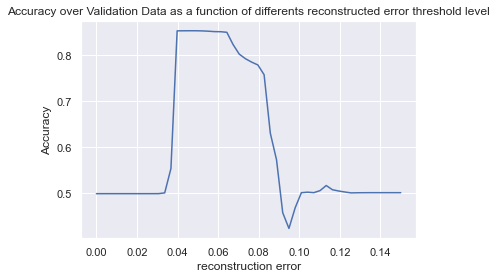

<Figure size 864x720 with 0 Axes>

In [16]:
plt.subplot(1, 1, 1)
plt.plot(metrics_df['threshold'], metrics_df['Accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('reconstruction error')
plt.title('Accuracy over Validation Data as a function of differents reconstructed error threshold level')
plt.figure(figsize=(12, 10))
plt.show()


### test data classification report :

In [17]:
x_pred, x_pred_latent_representations = vae.reconstruct(x_test)

anomalies = np.mean(abs(x_test - x_pred), axis=1) > best_th
anomalies_percentage = np.count_nonzero(anomalies) / len(anomalies)
print(classification_report(y_test, anomalies))
print(f"anomalies_percentage : {anomalies_percentage}")

              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     15733
         1.0       0.78      1.00      0.88     16007

    accuracy                           0.86     31740
   macro avg       0.89      0.86      0.85     31740
weighted avg       0.89      0.86      0.85     31740

anomalies_percentage : 0.6473219911783239


### pick the best VAE model :

<Figure size 864x720 with 0 Axes>

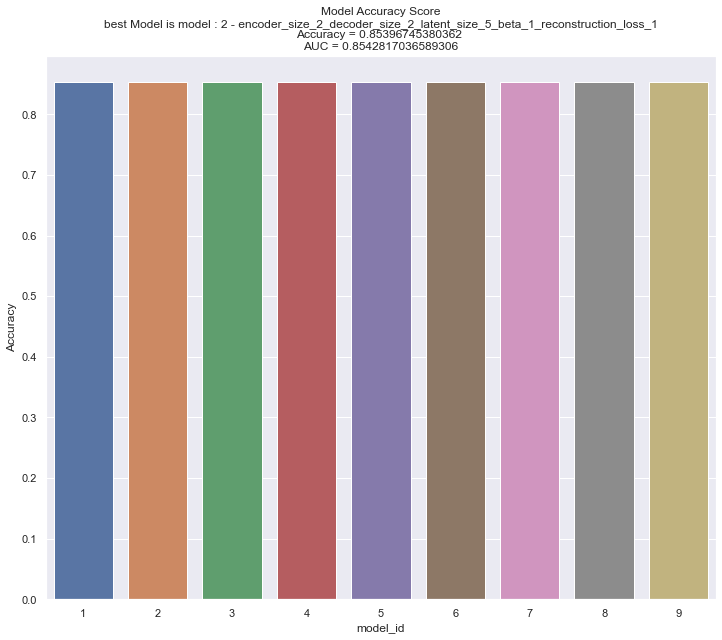

'encoder_size_2_decoder_size_2_latent_size_5_beta_1_reconstruction_loss_1'

In [18]:
base_file_name = 'results\\base_VAE_Model.csv'
plt.figure(figsize=(12, 10))

pick_best_model_from_csv([base_file_name])

### Beta VAE results  :
### training data latent space represention:

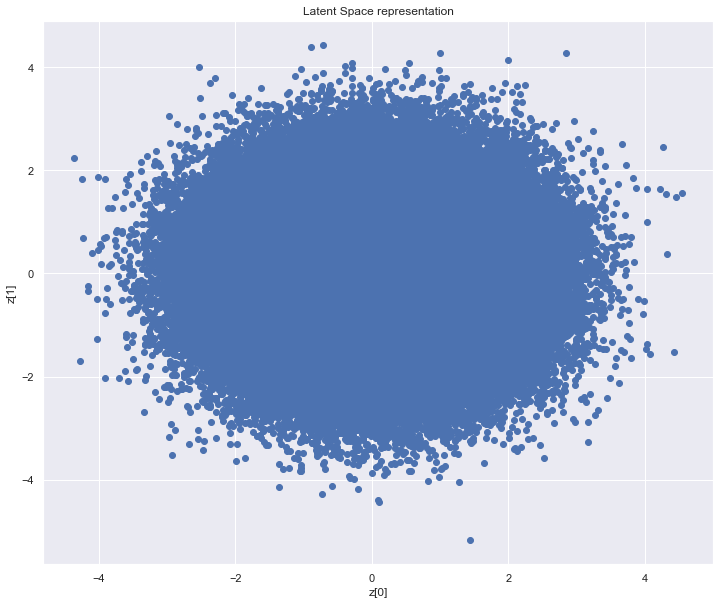

In [19]:
vae = load_model("model\\encoder_size_3_decoder_size_3_latent_size_2_beta_5_reconstruction_loss_1")
plot_latent_space(vae, x_train)

### training data reconstruction error:

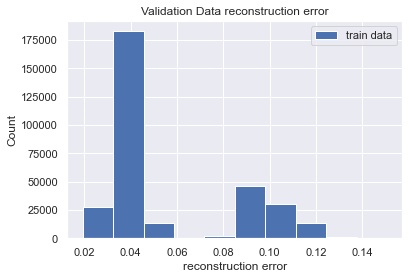

In [20]:
plot_reconstruction_error(vae, x_train)

### validation data reconstruction error

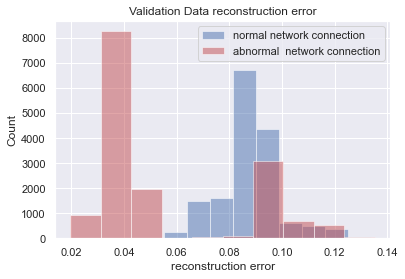

In [21]:
plot_reconstruction_error(vae, x_test, label = y_test )

### validation data latent space represention

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


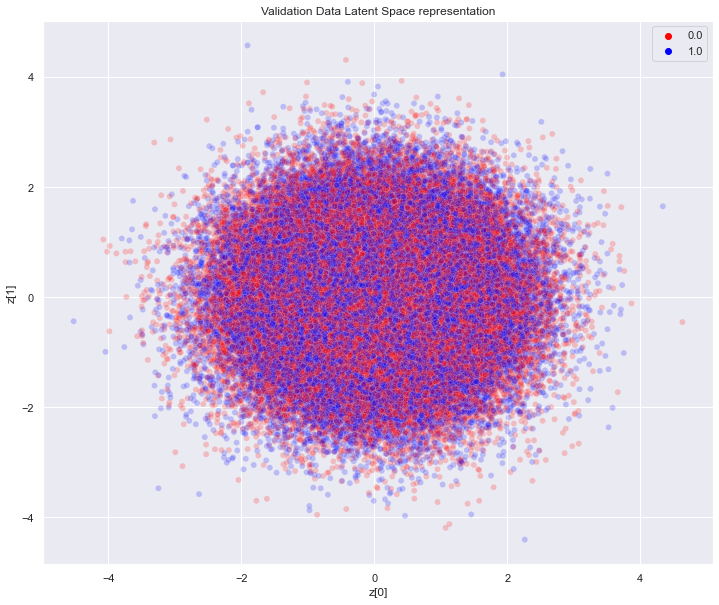

In [22]:
plot_label_latent_space(vae, X_val,y_val)

### pick the best resonstruction error value

In [23]:
x_val_pred, x_val_pred_latent_representations = vae.reconstruct(X_val)
metrics_df = metrics(X_val, x_val_pred, y_val)
best_th = get_best_threshold_value(metrics_df,["Accuracy"])

max value of Accuracy is 0.8534869799461239
Th is 0.04897959183673469


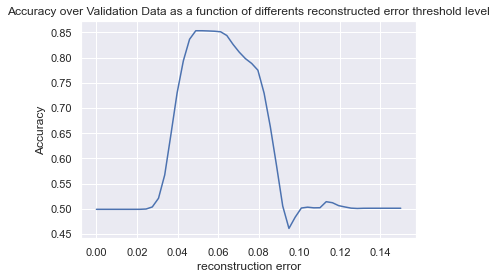

<Figure size 864x720 with 0 Axes>

In [24]:
plt.subplot(1, 1, 1)
plt.plot(metrics_df['threshold'], metrics_df['Accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('reconstruction error')
plt.title('Accuracy over Validation Data as a function of differents reconstructed error threshold level')
plt.figure(figsize=(12, 10))
plt.show()

### test data classification report :

In [25]:
x_pred, x_pred_latent_representations = vae.reconstruct(x_test)

anomalies = np.mean(abs(x_test - x_pred), axis=1) > best_th
anomalies_percentage = np.count_nonzero(anomalies) / len(anomalies)
print(classification_report(y_test, anomalies))
print(f"anomalies_percentage : {anomalies_percentage}")

              precision    recall  f1-score   support

         0.0       1.00      0.71      0.83     15733
         1.0       0.78      1.00      0.88     16007

    accuracy                           0.86     31740
   macro avg       0.89      0.86      0.85     31740
weighted avg       0.89      0.86      0.85     31740

anomalies_percentage : 0.6473850031505987


### different  beta VAEs comparison   :

<Figure size 864x720 with 0 Axes>

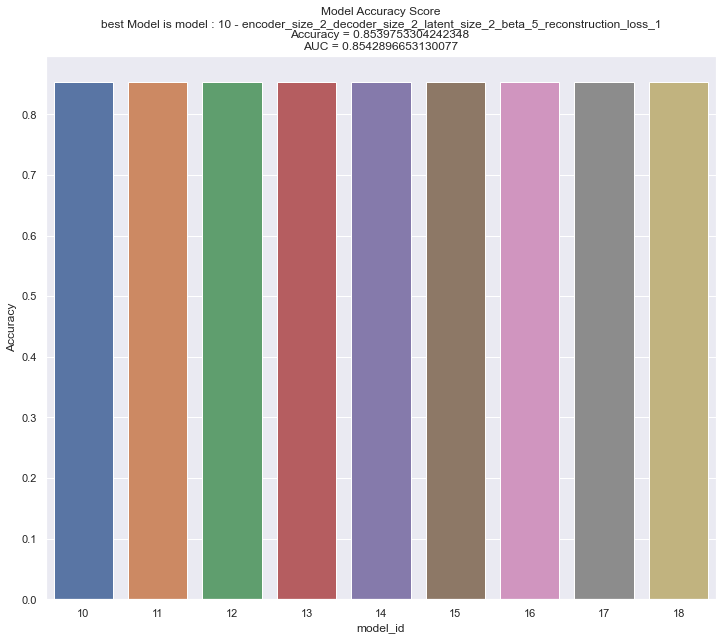

'encoder_size_2_decoder_size_2_latent_size_2_beta_5_reconstruction_loss_1'

In [26]:
beta_file_name = 'results\\beta_VAE_Models_result.csv'
sns.set()
plt.figure(figsize=(12, 10))

pick_best_model_from_csv([beta_file_name])

### Alpha VAE results  :
### training data latent space represention:

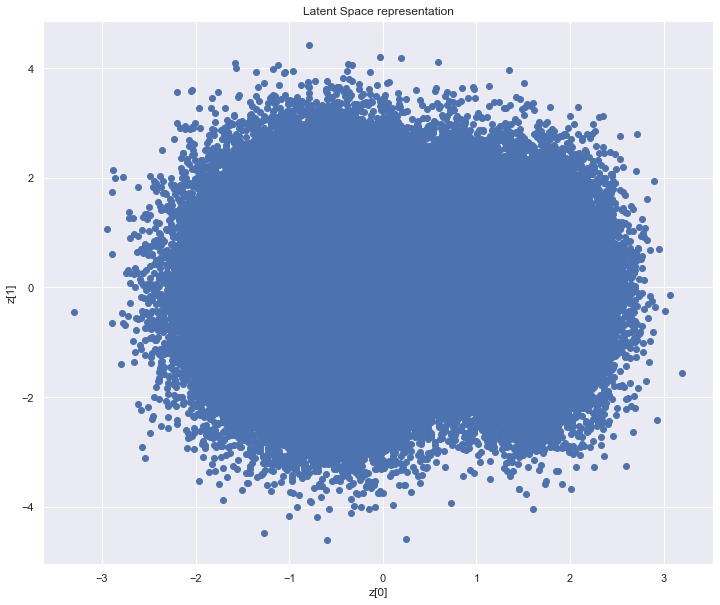

In [27]:
vae = VAE().load("model\\encoder_size_3_decoder_size_3_latent_size_2_beta_1_reconstruction_loss_100")
plot_latent_space(vae, x_train)

### training data reconstruction error:

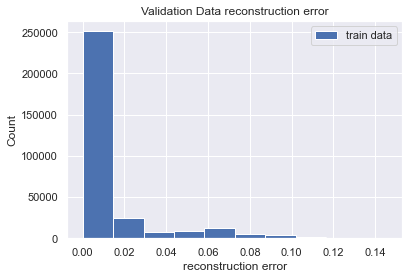

In [28]:
plot_reconstruction_error(vae, x_train)

### validation data reconstruction error

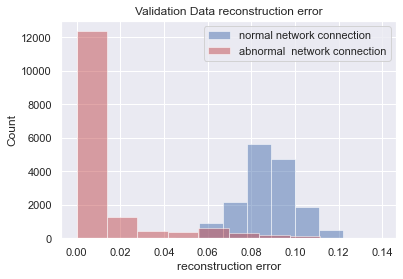

In [29]:
plot_reconstruction_error(vae, x_test, label = y_test )

### validation data latent space represention

D:\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


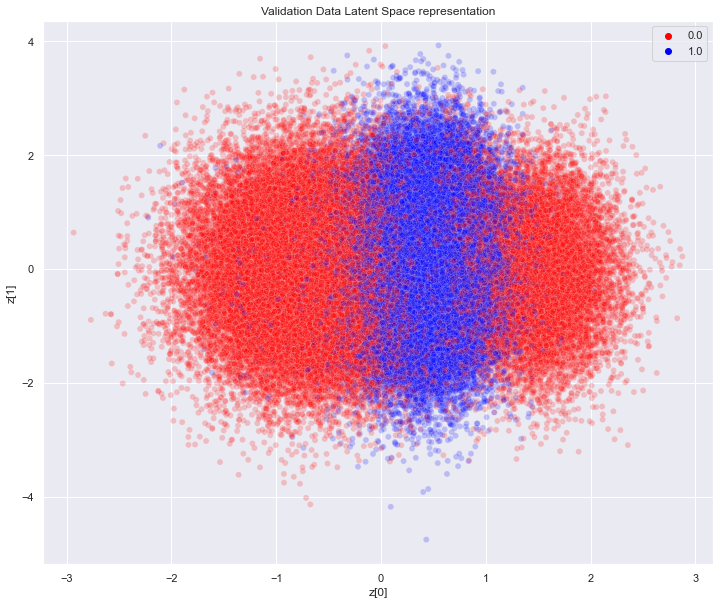

In [30]:
plot_label_latent_space(vae, X_val,y_val)

### pick the best reconstruction error value

In [31]:
x_val_pred, x_val_pred_latent_representations = vae.reconstruct(X_val)
metrics_df = metrics(X_val, x_val_pred, y_val)
best_th = get_best_threshold_value(metrics_df,["Accuracy"])

D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no pr

max value of Accuracy is 0.9529056853447597
Th is 0.055102040816326525


D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


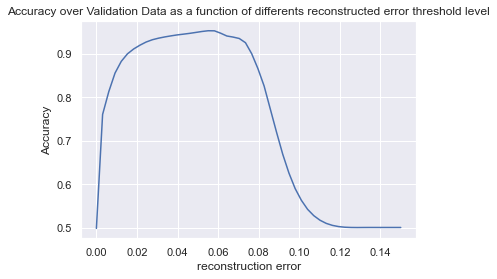

<Figure size 864x720 with 0 Axes>

In [32]:
plt.subplot(1, 1, 1)
plt.plot(metrics_df['threshold'], metrics_df['Accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('reconstruction error')
plt.title('Accuracy over Validation Data as a function of differents reconstructed error threshold level')
plt.figure(figsize=(12, 10))
plt.show()

### test data classification report :

In [33]:
x_pred, x_pred_latent_representations = vae.reconstruct(x_test)

anomalies = np.mean(abs(x_test - x_pred), axis=1) > best_th
anomalies_percentage = np.count_nonzero(anomalies) / len(anomalies)
print(classification_report(y_test, anomalies))
print(f"anomalies_percentage : {anomalies_percentage}")

              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95     15733
         1.0       0.92      0.99      0.96     16007

    accuracy                           0.95     31740
   macro avg       0.96      0.95      0.95     31740
weighted avg       0.96      0.95      0.95     31740

anomalies_percentage : 0.5428166351606806


### different Alpha VAEs comparison   :

<Figure size 864x720 with 0 Axes>

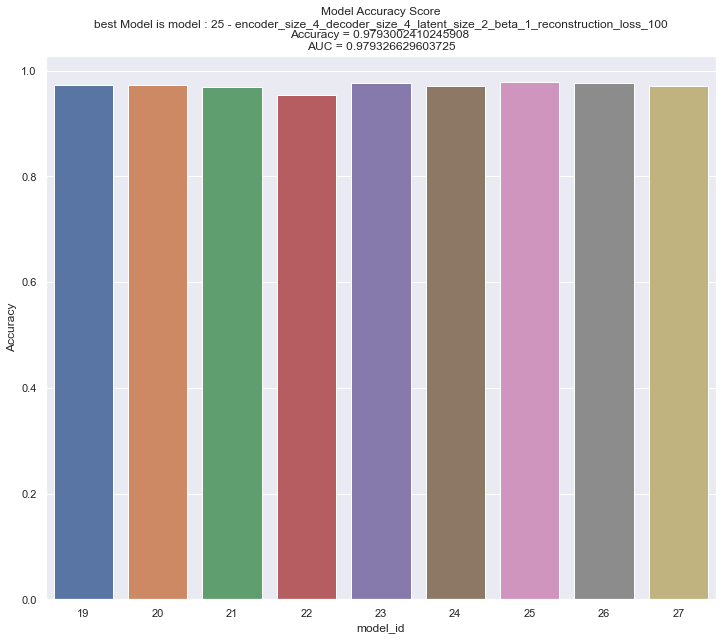

'encoder_size_4_decoder_size_4_latent_size_2_beta_1_reconstruction_loss_100'

In [34]:
reconstruction_loss_file_name = 'results\\reconstruction_loss_VAE_Models_result.csv'
sns.set()
plt.figure(figsize=(12, 10))

pick_best_model_from_csv([reconstruction_loss_file_name])

### all trained  VAEs models comparison   :

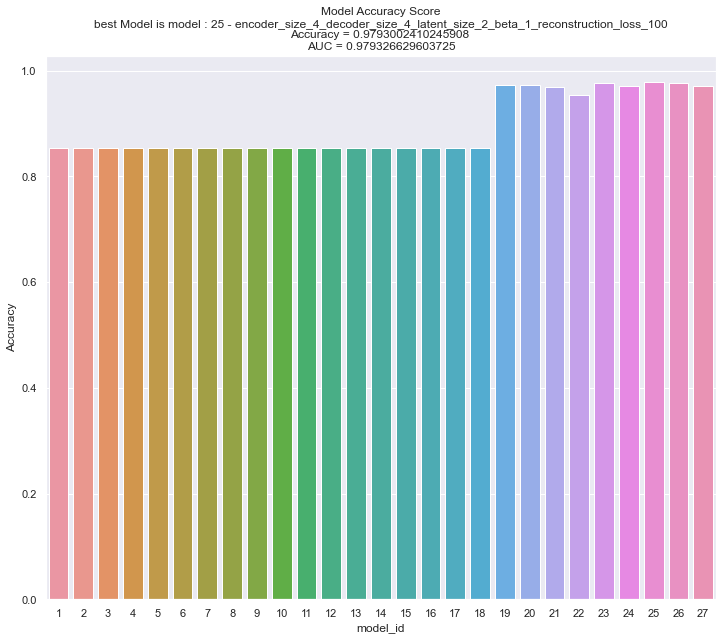

In [35]:
best_model = pick_best_model_from_csv([base_file_name,beta_file_name,reconstruction_loss_file_name])

### best model :

In [36]:
print(best_model)

encoder_size_4_decoder_size_4_latent_size_2_beta_1_reconstruction_loss_100


### validation data reconstruction error

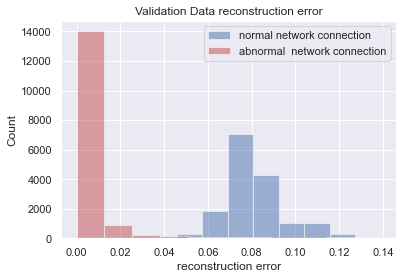

D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


max value of Accuracy is 0.9789851762000031
Th is 0.05204081632653061


D:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [37]:
vae = VAE().load(f"model\\{best_model}")
plot_reconstruction_error(vae, x_test, label = y_test )
x_val_pred, x_val_pred_latent_representations = vae.reconstruct(X_val)
metrics_df = metrics(X_val, x_val_pred, y_val)
best_th = get_best_threshold_value(metrics_df,["Accuracy"])


### pick the best resonstruction error value

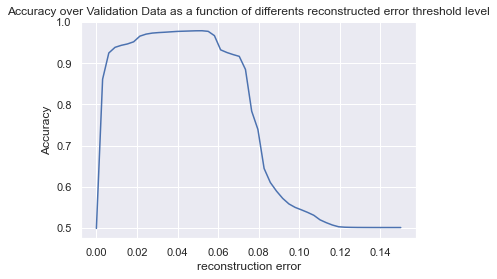

<Figure size 864x720 with 0 Axes>

In [38]:
plt.subplot(1, 1, 1)
plt.plot(metrics_df['threshold'], metrics_df['Accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('reconstruction error')
plt.title('Accuracy over Validation Data as a function of differents reconstructed error threshold level')
plt.figure(figsize=(12, 10))
plt.show()

In [39]:
x_val_pred, x_val_pred_latent_representations = vae.reconstruct(X_val)
metrics_df = metrics(X_val, x_val_pred, y_val)
best_th = get_best_threshold_value(metrics_df,["Accuracy"])

max value of Accuracy is 0.9791899683359852
Th is 0.05204081632653061


### test data classification report :

In [40]:
x_pred, x_pred_latent_representations = vae.reconstruct(x_test)

anomalies = np.mean(abs(x_test - x_pred), axis=1) > best_th
anomalies_percentage = np.count_nonzero(anomalies) / len(anomalies)
print(classification_report(y_test, anomalies))
print(f"anomalies_percentage : {anomalies_percentage}")

              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98     15733
         1.0       0.97      0.99      0.98     16007

    accuracy                           0.98     31740
   macro avg       0.98      0.98      0.98     31740
weighted avg       0.98      0.98      0.98     31740

anomalies_percentage : 0.515406427221172
